In [1]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans,KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

# print the JS visualization code to the notebook
shap.initjs()

# Load dataset

In [2]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split

In [3]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

# Train the model

In [4]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.278029


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

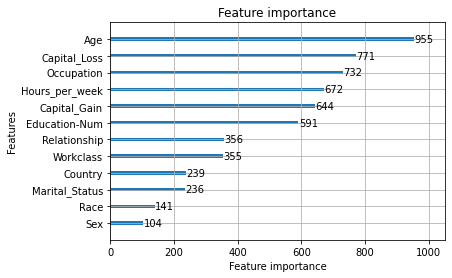

In [5]:
lgb.plot_importance(model)

# Explain predictions

In [6]:
explainer = shap.TreeExplainer(model)
# shap值
shap_values = explainer.shap_values(X)
print(explainer.expected_value)
# shap相互作用值
shap_interaction_values = explainer.shap_interaction_values(X)
print(explainer.expected_value)
# 主效应（shap相互作用值对角线上的值）
main_effects = np.diagonal(shap_interaction_values,axis1=1,axis2=2)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[2.4326672543732544, -2.4326672543732544]
-2.4326672543732544


## shap_values
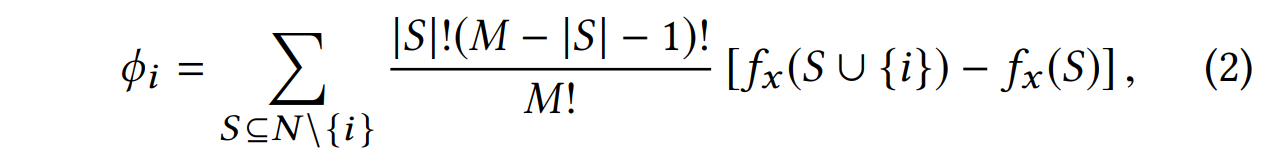
## shap_interaction_values
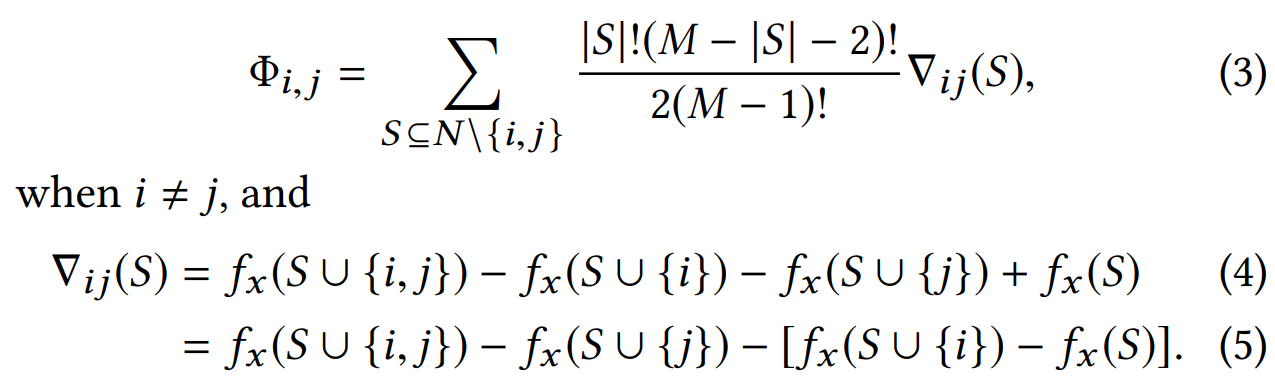
## main_effects
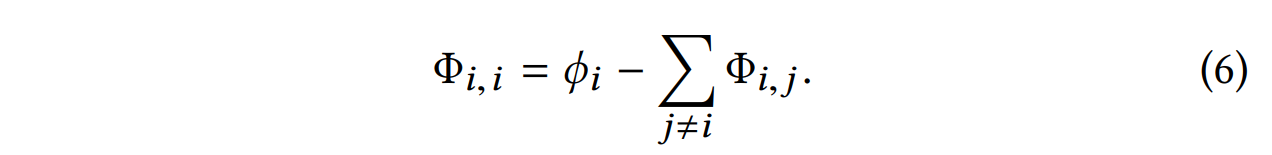

In [7]:
shap_values[0].shape,shap_values[1].shape,shap_interaction_values.shape,main_effects.shape

((32561, 12), (32561, 12), (32561, 12, 12), (32561, 12))

In [8]:
print(shap_interaction_values.shape)
# 验证 shap相互作用值的和 与 shap值 相等
print(shap_values[1][0,:])
print(np.sum(shap_interaction_values[0],axis=1))

(32561, 12, 12)
[ 0.49054848 -0.27539266  0.58470001 -0.31701933 -0.25643183 -0.77566161
  0.03209947  0.27542093 -2.46622737 -0.02499081 -0.12447309  0.01646595]
[ 0.49054848 -0.27539266  0.58470001 -0.31701933 -0.25643183 -0.77566161
  0.03209947  0.27542093 -2.46622737 -0.02499081 -0.12447309  0.01646595]


In [9]:
explainer.expected_value

-2.4326672543732544

# Visualize a single prediction

In [10]:
shap.force_plot(explainer.expected_value, shap_values[1][0,:], X_display.iloc[0,:])

In [11]:
g = explainer.expected_value + shap_values[1][0,:].sum()
g

-5.273629097885442

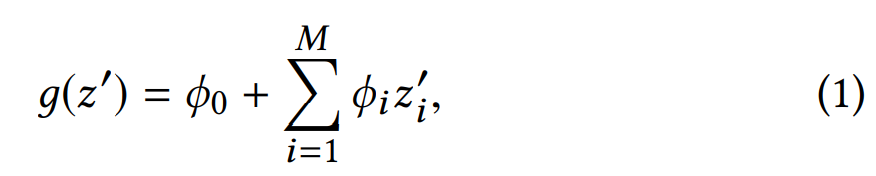

# Visualize many predictions

In [12]:
shap.force_plot(explainer.expected_value, shap_values[1][:1000,:], X_display.iloc[:1000,:])

# Supervised Clustering

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

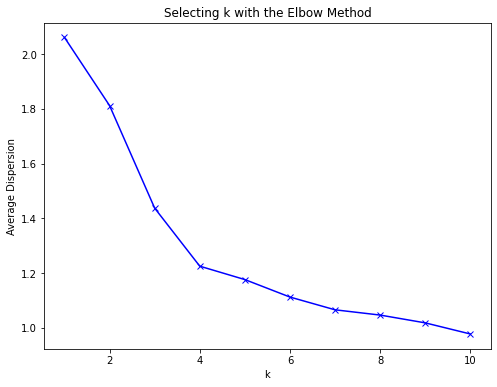

In [39]:

# 测试 9 种不同聚类中心数量下，每种情况的聚类质量，并作图。
K = range(1, 11)
meandistortions = []
for k in K:
    mbk = KMeans(n_clusters=k)
    mbk.fit(shap_values[1])
    meandistortions.append(sum(np.min(cdist(shap_values[1], mbk.cluster_centers_, 'euclidean'), axis=1))/shap_values[1].shape[0])
plt.figure(figsize=(8,6))
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Dispersion')
plt.title('Selecting k with the Elbow Method')
plt.show()

In [32]:
# 由上图观察 4 为肘点
mbk = KMeans(n_clusters=4)
mbk.fit(shap_values[1])
# 聚类中心
mbk_means_cluster_centers = mbk.cluster_centers_
print('类别数量：\t',len(mbk_means_cluster_centers))
# 为每行数据打聚类标签
mbk_means_labels = pairwise_distances_argmin(shap_values[1], mbk_means_cluster_centers)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


类别数量：	 4


In [33]:

# 合并标签 和 shap values
df = pd.DataFrame(shap_values[1],columns=X.columns)
df['sum_shap'] = df.sum(axis=1)
df1 = pd.DataFrame(mbk_means_labels,columns=['clustering_label'])
df = pd.concat([df,df1],axis=1)
# 按聚类标签和shap值  对数据重新排序
df = df.sort_values(by=['clustering_label','sum_shap'])
# Sample the clustered data
df_group = df.groupby(['clustering_label'])
sampled_df = pd.DataFrame()
for name,df_g in df_group:
    df_g = df_g.sample(n=500)
    sampled_df = pd.concat([sampled_df,df_g])
sampled_df = sampled_df.iloc[:,:-2]
sampled_df_index = sampled_df.index
sampled_df = sampled_df.values
# 展示数据 重排序
X_display_df = X_display.copy(deep=True)
X_display_df = X_display_df.loc[sampled_df_index]

In [34]:
# 绘制聚类后的shap values
shap.force_plot(explainer.expected_value, sampled_df,X_display_df) # df[:5000,:],X_display_df.iloc[:5000,:]

# SHAP Summary Plot

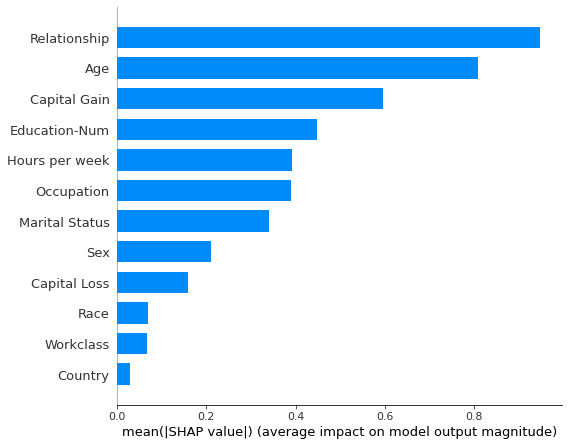

In [40]:
# Plot feature attributes(shap value) of two classes that we use bar of mean shap value
shap.summary_plot(shap_values[1], X, plot_type="bar")
# shap_values[1]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


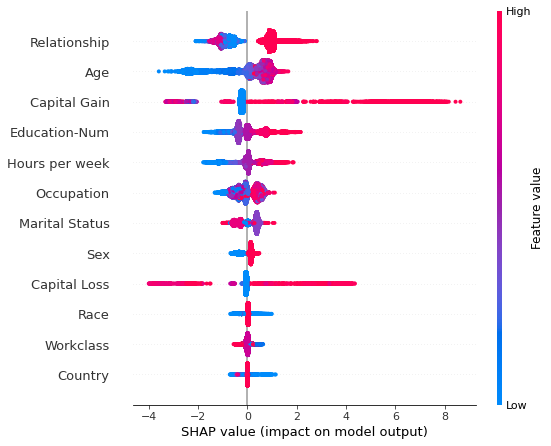

In [41]:
# Plot feature attributes(shap value) of good class that we use dot of shap values
shap.summary_plot(shap_values[1], X)

# SHAP Dependence Plots

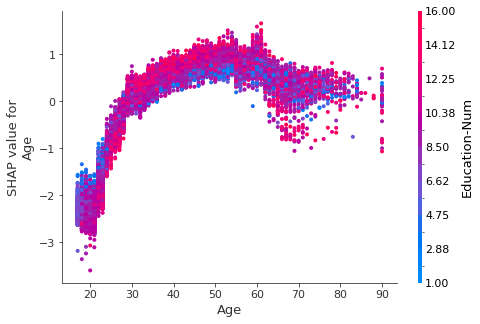

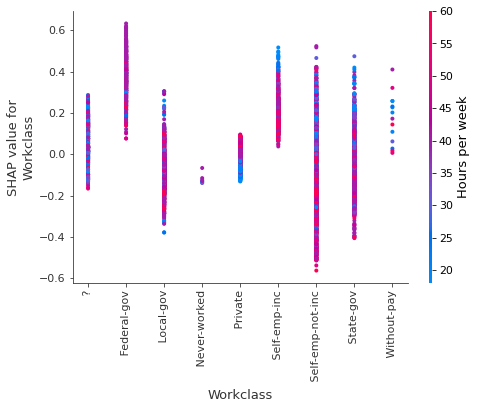

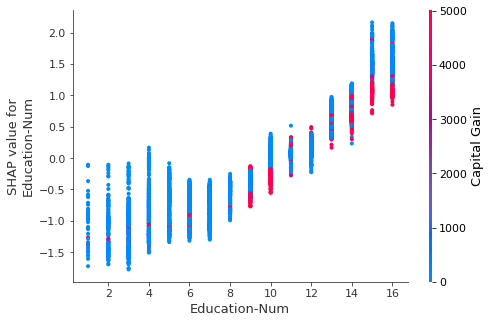

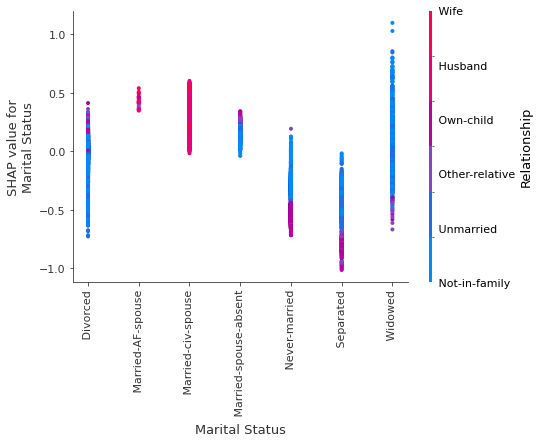

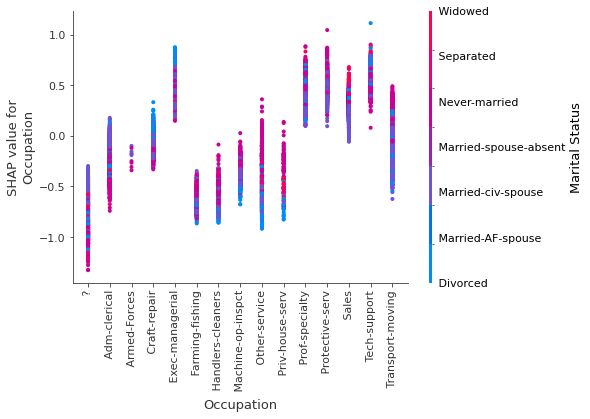

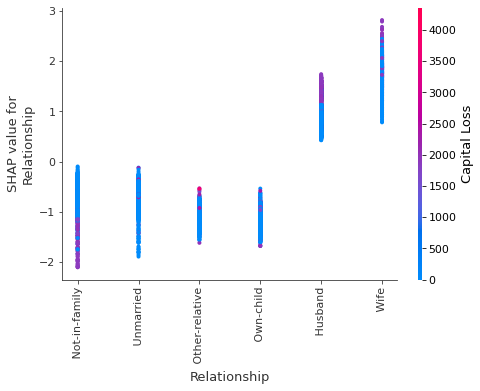

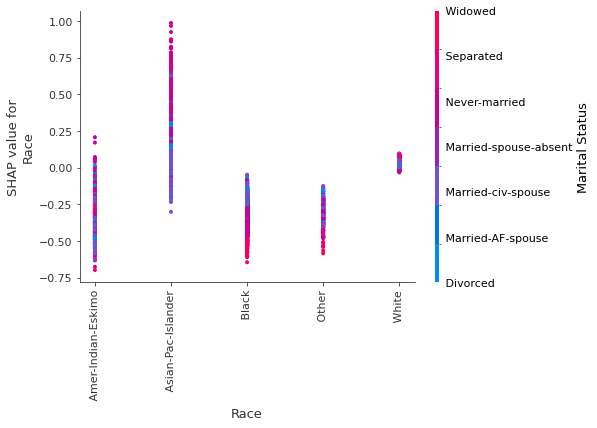

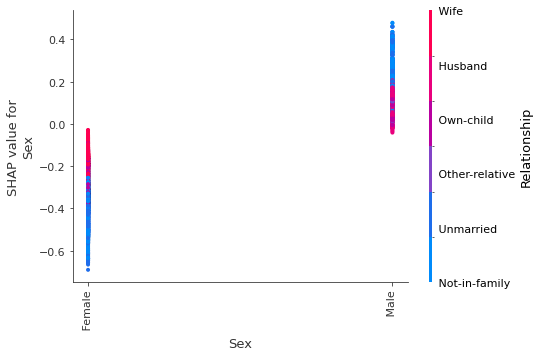

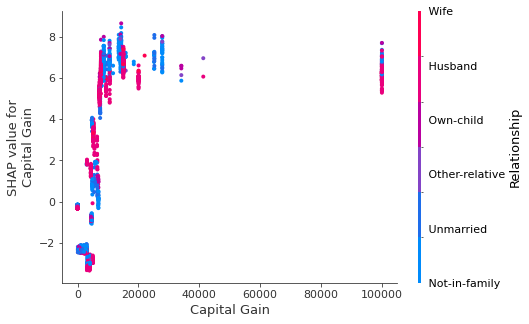

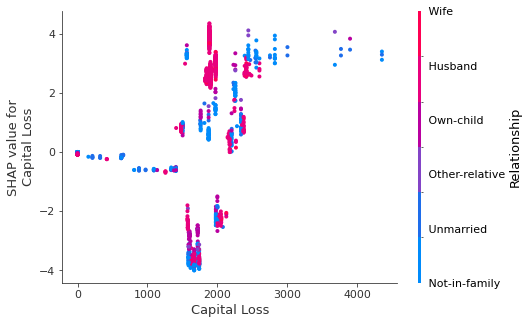

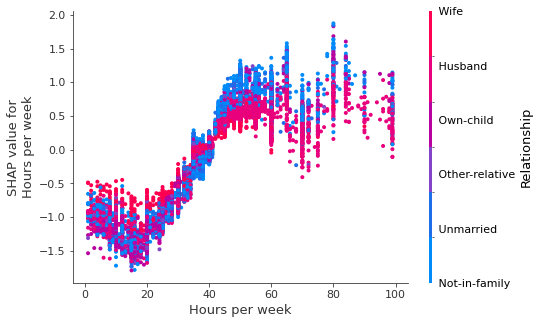

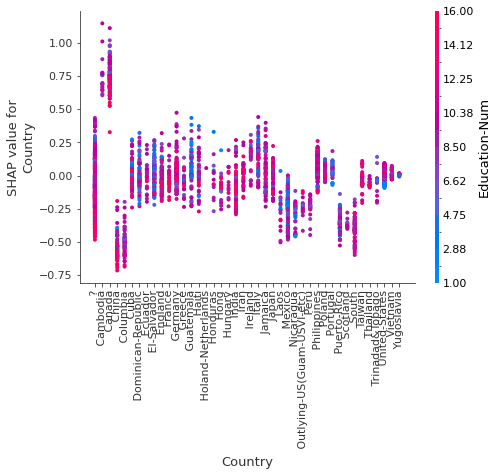

In [42]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X, display_features=X_display)